# Preamble

> This notebook contains the ground-truth copy of the code mixed with literate comments. All code in this directory is produced by running the cells in this notebook.

# Introduction

**Cortical visual prostheses** (CVPs) are devices implanted on the brain which aim to restore vision to blind people by stimulating the visual cortex.

Experiments have shown that stimulating the visual cortex produces visual percepts in both blind and sighted patients. These visual percepts are called **phosphenes** and are typically described as small round dots of colourless light like "a star in the sky." The idea behind most CVPs is to build images out of phosphenes, like how graphical displays are made out of pixels. 

But phosphenes are very limited. At the moment, we can only control the intensity of phosphenes (and, to some extent, their size). The locations of phosphenes follow the retinotopic mapping of the visual fields on the cortex, but the complexity of this mapping makes precisely controlling the positions of phosphenes in the visual field very difficult; it is much easier to instead place a regular grid of electrodes on the brain and map the phosphene locations after implantation. Other properties of phosphenes, such as their shape, individual brightness or colour, are highly variable and uncontrollable.

In addition, there are no empirical studies which describe what exactly is seen when we try to stimulate more than about five simultaneous phosphenes. The largest implant in a human used 64 electrodes, but there is inadequate description on what the implantee saw and how useful these percepts were (though the implantee purportedly was able to read large letterforms). New CVPs generally intend to stimulate on the order of hundreds of electrodes (such as 473 for the Monash Vision Group); it is not yet known what people will perceive when many electrodes are stimulate at once. Some studies have suggested that stimulating five electrodes, for example, does not produce five discrete phosphenes or a blended picture; rather, phosphenes which were stimulated by an electrode when only one electrode was stimulated completely disappear upon simultaneous stimulation as though they were not stimulated at all.

This begs the question: **how can phosphenes be used to convey useful information, given their known and unknown perceptual limitations?**

## Pattern-Based Approach

Using a pattern-based approach, we focus on **object identification**. That is, we attempt to create recognisable patterns that are matchable against object identities, and discard any location-based information.

The advantages of this approach are that:

1. By focusing on identity rather than location, stable patterns can be presented using the same phosphenes each time an object occurs in a scene. As the exact same pattern is presented each time, it may be easier to learn.

The disadvantages of this approach are that:

1. Only one object at a time can be shown.
2. If there is no location information, it may be hard to justify how this is useful in comparison to something less invasive; for example, an external camera linked to an earpiece could easily just speak out the identity of an object instead of presenting patterned vision. You could argue that presenting object identities through vision is beneficial because it doesn't take up another sensory modality, but this is a relatively small upside compared to the invasiveness of a brain implant.

## Location-Based Approach

Using a location-based approach, we focus on **object localisation**. 

## Rationale

# Phosphene Modelling

## Phosphene Rendering

In [1]:
%%writefile phosphenes.py
#!/usr/bin/env python

import numpy as np
from scipy.ndimage import gaussian_filter
import random
import math
from skimage import color

# CONSTANTS

XSIZE = 64
YSIZE = 64
PBASE = 2
SCALE = 6
EXSIZE = XSIZE // SCALE
EYSIZE = YSIZE // SCALE


def safebound(value: float, width: float, lower: float, upper: float):
    """ 
    Returns the bounded min and max about value with width.
    """
    vmin = int(max(lower, value - width))
    vmax = int(min(upper, value + width))
    return vmin, vmax

def bound(value:float, lower: float, upper:float):
    """
    Returns a bounded value.
    """
    if value > lower:
        if value < upper:
            return value
        else:
            return upper
    else:
        return lower

# Electrodes, which produce phosphenes.

class Electrode:
    def __init__(self, x: float, y: float, xsize : int = XSIZE, ysize : int = YSIZE, randomPos: float = 0):
        """
        Produces a phosphene for a single electrode.
        
        Args:
            x: float         - position in range [0, 1]. 
            y: float         - position in range [0, 1]
            randomPos: float - a scaling factor for random positioning. 
        """
        self.randomPos = randomPos
        self.x = bound(x + (random.random() - 0.5) * self.randomPos, 0, 1)
        self.y = bound(y + (random.random() - 0.5) * self.randomPos, 0, 1)
        self.xsize = xsize
        self.ysize = ysize

        self.size = PBASE * (0.5 + (4 * np.sqrt((self.x - 0.5) ** 2 + (self.y - 0.5) ** 2)) ** 2)

        self.rendered = self.render()

    def render(self):
        xmin, xmax = safebound(self.xsize * self.x, self.size, 0, self.xsize)
        ymin, ymax = safebound(self.ysize * self.y, self.size, 0, self.ysize)

        base = np.zeros((self.ysize, self.xsize))
        base[ymin:ymax, xmin:xmax] = 1

        return gaussian_filter(base, self.size)

class UniqueElectrode:
    """
    This class implements electrodes with unique characteristics such as colour and shape.
    """
    def __init__(self, x: float, y: float, xsize : int = XSIZE, ysize : int = YSIZE, randomPos: float = 0.001):
        self.x = bound(x + (random.random() - 0.5) * randomPos, 0, 1)
        self.y = bound(y + (random.random() - 0.5) * randomPos, 0, 1)
        self.size = PBASE * (0.5 + (4 * np.sqrt((self.x - 0.5) ** 2 + (self.y - 0.5) ** 2)) ** 2)
        self.colour = np.random.random(3)
        # xmod and ymod modify the shape of the phosphene
        self.xmod = 1 + (random.random()-0.5) * 3
        self.ymod = 1 + (random.random()-0.5) * 3
        self.xsize = xsize
        self.ysize = ysize

        self.rendered = self.render()

    def render(self):
        xmin, xmax = safebound(self.xsize * self.x, self.size*self.xmod, 0, self.xsize)
        ymin, ymax = safebound(self.ysize * self.y, self.size*self.ymod, 0, self.ysize)

        base = np.zeros((self.ysize, self.xsize, 3))
        base[ymin:ymax, xmin:xmax, :] = self.colour

        return gaussian_filter(base, self.size * (random.random() ** 0.3))

# Grids, which are composed of electrodes.

class RegularGrid:
    def __init__(self, exsize: int = EXSIZE, eysize: int = EYSIZE, xsize=XSIZE, ysize=YSIZE):
        """
        
        Args:
            exsize: int - x size of electrode grid 
            eysize: int - y size of electrode grid
        """
        self.exsize = EXSIZE
        self.eysize = EYSIZE
        self.grid = [
            Electrode(x / exsize, y / eysize, xsize=xsize, ysize=ysize)
            for x in range(exsize)
            for y in range(eysize)
        ]

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1) * 2 - 1
        # return (summed / summax) * 2 - 1

class IrregularGrid:
    def __init__(self, randomPos=2, exsize=EXSIZE, eysize=EYSIZE, xsize=XSIZE, ysize=YSIZE):
        self.exsize = EXSIZE
        self.eysize = EYSIZE
        self.grid = [
            Electrode(0.5 + (x / exsize) / 2, y / eysize, xsize=xsize, ysize=ysize, randomPos=randomPos )
            for x in range(exsize)
            for y in range(eysize)
        ]

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1) * 2 - 1
        # return (summed / summax) * 2 - 1

class PolarRegularGrid:
    def __init__(self, nrho, ntheta, xsize=XSIZE, ysize=YSIZE):
        self.nrho   = nrho
        self.ntheta = ntheta
        self.grid = [
            # Need to think of better way to scale.
            Electrode(((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.cos((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                      ((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.sin((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                      xsize = xsize,
                      ysize = ysize,
                     )
            # Ensure the central electrodes are actually visible by adding 1 to zero.
            for rho in range(1, nrho+1)
            for theta in range(ntheta)
        ]
        
        self.renders = tf.convert_to_tensor(np.array([e.rendered for e in self.grid]), dtype=tf.float32)

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1) * 2 - 1
        # return (summed / summax) * 2 - 1
        
    def render_tensor(self, tensor):
        reshaped = tf.transpose(tf.reshape(tf.tile(tensor, tf.constant([64])), (64, 144, 1)), perm=[1, 0, 2])
        product = reshaped * self.renders
        summed = tf.reduce_sum(product, axis=0)
        return tf.clip_by_value(summed, 0, 1) * 2 - 1

class PolarRegularUniqueGrid:
    def __init__(self, nrho, ntheta, xsize=XSIZE, ysize=YSIZE):
        self.nrho   = nrho
        self.ntheta = ntheta
        self.grid = [
            # Need to think of better way to scale.
            UniqueElectrode(((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.cos((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            ((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.sin((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            xsize = xsize,
                            ysize = ysize,
                           )
            # Ensure the central electrodes are actually visible by adding 1 to zero.
            for rho in range(1, nrho+1)
            for theta in range(ntheta)
        ]
        
        self.renders = tf.convert_to_tensor(np.array([e.rendered for e in self.grid]), dtype=tf.float32)

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1)
        # return (summed / summax) * 2 - 1
        
    def render_tensor(self, tensor):
        reshaped = tf.transpose(tf.reshape(tf.tile(tensor, tf.constant([64])), (64, 144, 1)), perm=[1, 0, 2])
        product = reshaped * self.renders
        summed = tf.reduce_sum(product, axis=0)
        return tf.clip_by_value(summed, 0, 1) * 2 - 1

class NonLinearInteractionGrid:
    def __init__(self, nrho, ntheta, xsize=XSIZE, ysize=YSIZE):
        self.nrho   = nrho
        self.ntheta = ntheta
        self.grid = [
            # Need to think of better way to scale.
            UniqueElectrode(((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.cos((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            ((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.sin((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            xsize = xsize,
                            ysize = ysize,
                           )
            # Ensure the central electrodes are actually visible by adding 1 to zero.
            for rho in range(1, nrho+1)
            for theta in range(ntheta)
        ]

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        #return np.clip(summed, 0, 1)
        return (summed / summax) * 2 - 1

        
        
# STIMULUS

class Stimulus:
    def __init__(self, image, grid, xpos=0, ypos=0):
        self.original = image
        self.shape = self.original.shape
        
        self.padder = np.zeros((3 * self.shape[0], 3 * self.shape[1]))
        self.padder[self.shape[0]:2*self.shape[0], self.shape[1]:2*self.shape[1]] = self.original
        
        self.xpos = xpos
        self.ypos = ypos
        
        self.image = self.getImage()
        
        self.grid = grid
        self.sampleWidth = 6
        
        self.vector = self.process()
            
    def get_params(self, x : float, y : float):
        
        ymin = bound(int(self.shape[0] * y - self.sampleWidth // 2), 0, self.shape[0] - 1)
        ymax = bound(int(self.shape[0] * y + self.sampleWidth // 2), 0, self.shape[0] - 1)
        xmin = bound(int(self.shape[1] * x - self.sampleWidth // 2), 0, self.shape[1] - 1)            
        xmax = bound(int(self.shape[1] * x + self.sampleWidth // 2), 0, self.shape[1] - 1)

        vals  = self.image[ymin:ymax, xmin:xmax]
        return np.mean(vals)
    
    def getImage(self):
        """ Based on xpos and ypos, get the image view from the padder.
        """
        
        xstart = self.shape[0] - int(self.xpos * self.shape[0])
        ystart = self.shape[1] - int(self.ypos * self.shape[1])
        
        return self.padder[ystart:ystart+self.shape[1], xstart:xstart+self.shape[0]]

    def process(self):
        """ Converts the stimulus into a brightness vector for the
        """

        params = [self.get_params(e.x, e.y) for e in self.grid.grid]
        return params
        #flattened = self.image.flatten(order="C")
    
    def setPos(self, xpos: float, ypos: float):
        """Translate the image. xpos and ypos lie in the range (-1, 1)
        """
        self.xpos = xpos
        self.ypos = ypos
        self.image = self.getImage()
        self.vector = self.process()
        
        
# TESTING ONLY 

import tensorflow as tf
tf.executing_eagerly()
import keras

input_shape = (72, 72)

encoder_path = "./data/models/encoder_model.h5"
encoder = tf.keras.models.load_model(encoder_path)

encoder = make_encoder_model()

class StimulusNet(Stimulus):
    
    def process(self):
        image_tensor = tf.convert_to_tensor(np.array([color.rgb2gray(self.image)]), dtype=tf.float32)
        return encoder(image_tensor).numpy()[0]

Overwriting phosphenes.py


In [3]:
%run phosphenes.py

Using TensorFlow backend.


## Digit Experiment

In [18]:
%%writefile digits.py
#!/usr/bin/env python
"""
This script runs a digit recognition psychophysics session.
"""

# # Setup

import numpy as np
import json
import phosphenes
from phosphenes import Stimulus
from datetime import datetime
from argparse import ArgumentParser
from psychopy import visual, core, gui, event
from box import Box
from psychopy.sound.backend_pygame import SoundPygame
from psychopy.tools.filetools import fromFile, toFile
from skimage import color
from imageio import imread
from random import random, choices
from PIL import Image

# I'm setting up a config dictionary with dot-syntax so it can be serialised 
# and saved with the session. I prefer explicitly keeping track of state.

config = Box({})

# Parsing the command line arguments, especially for testing.
parser = ArgumentParser(description='Digit recognition task.')

# Define command line arguments.
argspec = {
    'testing': {
        'action': 'store_const',
        'const': True,
        'default': False,
        'dest': 'testing',
        'help': 'Test the experiment and save the data.'
    },
    'ntrials': {
        'type': int,
        'nargs': '?',
        'default': 5,
        'help': 'Number of trials for the experiment.'
    },
    'ncues': {
        'type': int,
        'nargs': '?',
        'default': 10,
        'help': 'Number of cues per trial. Should be a multiple of 10 (for now) for digit stream.'
    },
    'grid': {
        'type': str,
        'nargs': '?',
        'default': 'polarRegular',
        'help': 'The grid type for rendering. One of regular, irregular, polarRegular, polarRegularUnique, or nonLinear.'
    },
    'processor': {
        'type': str,
        'nargs': '?',
        'default': 'direct',
        'help': 'The processor for the session. One of brightness of learner.'
    },
    'no-numpad': {
        'action': 'store_const',
        'const': True,
        'default': False,
        'dest': 'noNumpad',
        'help': 'Flags that normal number keys instead of numpad should be used.'
    }
}

# Add arguments to the parser.
[parser.add_argument(f'--{k}', **v) for k, v in argspec.items()]

# Parse the arguments and save into config.
args = parser.parse_args()
config.TESTING        = args.testing
config.NTRIALS        = args.ntrials
config.NCUES          = args.ncues
config.GRID_TYPE      = args.grid
config.PROCESSOR_TYPE = args.processor
config.NO_NUMPAD      = args.noNumpad


# First, we define the constants for the window size of the experiment.
# `XSIZE` and `YSIZE` refer to the size of the window on the screen.
# `EXSIZE` and `EYSIZE` refer to the size of the image data (i.e. how many 
# electrodes there are). 
# `SCALE` links the two. 

config.XSIZE  = 128
config.YSIZE  = 128
config.SCALE  = 12
config.EXSIZE = config.XSIZE // config.SCALE
config.EYSIZE = config.YSIZE // config.SCALE

# Next, we load the stimulus. Opening the image files can be expensive
# so we're doing at this at the very start and loading them into a 
# variable. 

# `IMAGE_TEMPLATE` is a string of the filepath of the stimulus digit images.
config.IMAGE_TEMPLATE = './data/digit-images-aliased/{}.png'

# `IMAGE_SIZE` is an (int, int) tuple of the image size of the first image.
# We assume that each image is of the same size as the image labelled "0"
config.IMAGE_SIZE = np.shape(imread(config.IMAGE_TEMPLATE.format(0)))  

# `IMAGE_SCALE` is an int describing the ratio of electrode size to image size.
# It assumes that EXSIZE == EYSIZE and the input images are square.
# This may need changing later. 
config.IMAGE_SCALE = config.EXSIZE / config.IMAGE_SIZE[0]  

# `IMAGES` holds the original digit images.
config.IMAGES = [np.flipud(color.rgb2gray(imread(config.IMAGE_TEMPLATE.format(digit)))) for digit in range(10)]

# `STIMULI` contains a list of numpy arrays.
# Each element in the list holds the image data (in greyscale at the moment) 
# for the digit equal to its index.
config.STIMULI = [
    np.array(Image.fromarray(image).resize((config.EXSIZE, config.EYSIZE)))
    for image in config.IMAGES
]

# We initiate a grid of electrodes.
grids = {
    'regular':   lambda: phosphenes.RegularGrid(exsize=config.EXSIZE, eysize=config.EYSIZE, xsize=config.XSIZE, ysize=config.YSIZE),
    'irregular': lambda: phosphenes.IrregularGrid(exsize=config.EXSIZE, eysize=config.EYSIZE, randomPos=0.1, xsize=config.XSIZE, ysize=config.YSIZE),
    'polarRegular': lambda: phosphenes.PolarRegularGrid(nrho=config.EXSIZE, ntheta=config.EYSIZE, xsize=config.XSIZE, ysize=config.YSIZE),
    'polarRegularUnique': lambda: phosphenes.PolarRegularUniqueGrid(nrho=config.EXSIZE, ntheta=config.EYSIZE, xsize=config.XSIZE, ysize=config.YSIZE),
    'nonLinear': lambda: phosphenes.NonLinearInteractionGrid(nrho=config.EXSIZE, ntheta=config.EYSIZE, xsize=config.XSIZE, ysize=config.YSIZE),
}

config.GRID = grids[config.GRID_TYPE]()

# We initiate the stimulus processor type.

processors = {
    'direct': phosphenes.Stimulus,
    'net': phosphenes.StimulusNet,
}

config.PROCESSOR = processors[config.PROCESSOR_TYPE]

# Templates for data paths.
config.DATETIME_FORMAT       = '%Y-%m-%d_%H-%M-%S'
config.DIGIT_SOUND_TEMPLATE  = './data/digit-voice/{}-alt.wav'

base_dir = './data/psychophysics-sessions/'

if config.TESTING:
    config.CONFIG_FILE_TEMPLATE  = base_dir + 'tests/{}_{}_config.json'
    config.SESSION_FILE_TEMPLATE = base_dir + 'tests/{}_{}_session.csv'
    config.MOUSE_FILE_TEMPLATE   = base_dir + 'tests/{}_{}_mouse.csv'
else:
    config.CONFIG_FILE_TEMPLATE  = base_dir + 'participants/{}_{}_config.json'
    config.SESSION_FILE_TEMPLATE = base_dir + 'participants/{}_{}_session.csv'
    config.MOUSE_FILE_TEMPLATE   = base_dir + 'participants/{}_{}_mouse.csv'

# Parameters for sound.
config.CORRECT_NOTE   = 'G'
config.INCORRECT_NOTE = 'Csh'
config.NOTE_DURATION  = 0.1
config.NOTE_VOLUME    = 0.5

# Session data.
config.SESSION_VARS = ['trial', 'cue', 'digit', 'keypress', 'cuetime', 'trialtime', 'sessiontime']
config.MOUSE_VARS   = ['trial', 'cue', 'digit', 'xmouse', 'ymouse', 'cuetime', 'trialtime', 'sessiontime']

# Output templates based on session data.
config.SESSION_HEADER       = ','.join(config.SESSION_VARS) + '\n'
config.SESSION_ROW_TEMPLATE = ','.join(['{' + word + '}' for word in config.SESSION_VARS]) + '\n'
config.MOUSE_HEADER         = ','.join(config.MOUSE_VARS) + '\n'
config.MOUSE_ROW_TEMPLATE   = ','.join(['{' + word + '}' for word in config.MOUSE_VARS]) + '\n'

# Mouse recording interval in seconds.
config.MOUSE_RECORD_INTERVAL = 0.2

# Text.
config.PROMPT_TEXT = "{}% complete.\n\nPress any key when ready."
config.END_TEXT    = "Thank you. \n\nPress any key to exit."

# If testing, the blank image.
if config.TESTING:
    config.BLANK_FILE = config.IMAGE_TEMPLATE.format('blank')
    config.BLANK_IMAGE = np.flipud(color.rgb2gray(imread(config.BLANK_FILE)))
    config.TEST_WINDOW_XSIZE = 480
    config.TEST_WINDOW_YSIZE = 480

# Keypress during a trial.
if config.NO_NUMPAD:
    config.KEY_LIST=[str(x) for x in range(10)]
else:
    config.KEY_LIST = ["num_" + str(x) for x in range(10)]

# When saving the config, excluding some variables due to size.
config.EXCLUDED = ['STIMULI', 'GRID', 'IMAGES', 'BLANK_IMAGE', 'PROCESSOR']


# Here, we make our main experiment, only if called from the command line.
if __name__ == "__main__":
    
    # We initiate the user details and present a dialog to the user to get those details.
    config.details = {"datetime": datetime.strftime(datetime.now(), config.DATETIME_FORMAT), "participant": ""}
    dialog         = gui.DlgFromDict(config.details, title="PROTOTYPE", fixed=["datetime"])
    
    # We interpret the dialog actions and initiate data files if proceeding.
    if dialog.OK:
        config.configFile  = config.CONFIG_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
        config.sessionFile = config.SESSION_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
        config.mouseFile = config.MOUSE_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
    else:
        core.quit()

    # Clocks that keep track of the experiment.
    clockSession = core.Clock()
    clockTrial   = core.Clock()
    clockCue     = core.Clock()
    mouseRecord  = core.Clock()

    # We initiate some generic sounds for correct and incorrect.
    correctSound   = SoundPygame(value=config.CORRECT_NOTE, secs=config.NOTE_DURATION)
    incorrectSound = SoundPygame(value=config.INCORRECT_NOTE, secs=config.NOTE_DURATION)
    
    correctSound.setVolume(config.NOTE_VOLUME)
    incorrectSound.setVolume(config.NOTE_VOLUME)
    
    # And we initiate the sounds for each digit.
    digitSounds = [SoundPygame(value=config.DIGIT_SOUND_TEMPLATE.format(digit)) for digit in range(10)]
    
    # Now we save the config for this session.
    with open(config.configFile, 'w+') as configFile:
        json.dump({k:v for k, v in config.items() if k not in config.EXCLUDED}, configFile)

    # We initiate a testing window if this is a testing run.
    if config.TESTING:
        testWin = visual.Window([config.TEST_WINDOW_XSIZE, config.TEST_WINDOW_YSIZE],
                                pos=(200,200), allowGUI=False, winType='pyglet')
        win = visual.Window([config.TEST_WINDOW_XSIZE, config.TEST_WINDOW_YSIZE],
                            pos=(200+config.TEST_WINDOW_XSIZE, 200), allowGUI=False, winType='pyglet', color=-1)
    else:
        # We make a window for the experiment.
        win = visual.Window(fullscr=True, allowGUI=False, winType='pyglet', color=-1)

    # Start the mouse event
    mouse = event.Mouse(visible=False, win=win)
        
    # We now start the experiment loop.
    with open(config.sessionFile, 'w+') as outfile, open(config.mouseFile, 'w+') as mousefile:

        # We first write the header of the csv file.
        outfile.write(config.SESSION_HEADER)
        mousefile.write(config.MOUSE_HEADER)

        # Start the trial loop.
        for trial in range(config.NTRIALS):

            # Set the trial clock to 0.
            # This clock will start counting from the wait screen, so includes that time..
            clockTrial.reset()
            
            # If testing, show the blank.
            if config.TESTING:
                blankStimulus = config.PROCESSOR(config.BLANK_IMAGE, config.GRID)
                rendered = config.GRID.render(blankStimulus.vector)
                imageStimulus = visual.ImageStim(testWin, image=rendered, size=(2,2))
                imageStimulus.draw(); testWin.flip()

            # Show a prompt on grey background at the beginning of the trial and wait for a keypress.
            bg     = visual.GratingStim(win, tex=None, mask=None, size=2, units='norm', color=0)
            prompt = visual.TextStim(win, text=config.PROMPT_TEXT.format(trial * 100 // config.NTRIALS))
            bg.draw(); prompt.draw(); win.flip(); event.waitKeys(clearEvents=True)

            # Create a stream of digits of length NCUES for the trial.
            stream = choices(range(10), k=config.NCUES)

            # Start the cue loop.
            for cue in range(config.NCUES):
                
                # Get a digit from the stream and initialise the stimulus.
                digit    = stream.pop()
                image    = config.IMAGES[digit]
                stimulus = config.PROCESSOR(image, config.GRID)
                
                # If this is a testing run, also draw the original image.
                if config.TESTING:
                    originalImage = visual.ImageStim(testWin, image=color.rgb2gray(image), size=(2,2))
                    originalImage.draw(); testWin.flip()
                    
                # Clear the event buffer
                event.clearEvents()      
                
                # Set the mouse to the center. Might turn off, not sure which is better.
                mouse.setPos((0,0))    
 
                # Initialise a False keypress
                keypressRaw = False
        
                # Set the cue clock to 0.
                clockCue.reset()

                # Set the mouse recording clock to 0
                mouseRecord.reset()
                
                # Loop until the keypress
                while not keypressRaw:
                    
                    # Get the mouse position and set the stimulus to the position.
                    newPos = mouse.getPos()
                    stimulus.setPos(*newPos)
                    
                    if mouseRecord.getTime() > config.MOUSE_RECORD_INTERVAL:
                    
                        mouseRow = config.MOUSE_ROW_TEMPLATE.format(
                            trial=trial,
                            cue=cue,
                            digit=digit,
                            xmouse=newPos[0],
                            ymouse=newPos[1],
                            cuetime=clockCue.getTime(),
                            trialtime=clockTrial.getTime(),
                            sessiontime=clockSession.getTime(),
                        )
                        mousefile.write(mouseRow)
                        
                        mouseRecord.reset()
                
                    # Render the stimulus
                    rendered = config.GRID.render(stimulus.vector)

                    # Create an image stimulus out of the rendered image.
                    # Then show the stimulus.
                    # Ensure stimulus is square on full screen window, assuming window has greater x dim than y dim.
                    imstim = visual.ImageStim(win, image=rendered, size = (2 * win.size[1] / win.size[0], 2))
                    imstim.draw(); win.flip()
                    
                    # Wait for a keypress. 
                    # We only need the first keypress, and want the key input from the numpage.
                    keypresses = event.getKeys(keyList = config.KEY_LIST)
                    if keypresses:
                        keypressRaw = keypresses[0]
                    #keypressRaw, *_ = event.waitKeys(clearEvents=True, keyList=config.KEY_LIST)
                
                # Check if their input was correct. 
                # Numpad keys are prepended with 'num_', so we strip it out.
                keypress = keypressRaw.strip('num_')
                correct  = (digit == int(keypress))
                
                # Create the data line.
                row = config.SESSION_ROW_TEMPLATE.format(
                    trial=trial,
                    cue=cue,
                    digit=digit,
                    keypress=keypress, 
                    cuetime=clockCue.getTime(),
                    trialtime=clockTrial.getTime(),
                    sessiontime=clockSession.getTime(),
                )
                
                # Write the data line to the session file.
                outfile.write(row)

                # Play the feedback sound.
                correctSound.play() if correct else incorrectSound.play()
                
                # Play the digit sound.
                digitSounds[digit].play()
                
        # At the end of all the trials, show an end screen and wait for key press
        # to exit.
        bg  = visual.GratingStim(win, tex=None, mask=None, size=2, units='norm', color=0)
        end = visual.TextStim(win, text=config.END_TEXT)
        bg.draw(); end.draw(); win.flip(); event.waitKeys(clearEvents=True)


Overwriting ../digits.py


In [1]:
# %run digits.py

# Generating Patterns

## Digits

### Setup

In [4]:
import glob
import imageio
import numpy as np
import os
import PIL
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cv2
import random

from skimage import color
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tensorflow.keras import layers, Sequential
from IPython import display
from datetime import datetime

In [5]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [6]:
gridType= PolarRegularGrid
gridParam1 = 12
gridParam2 = 12
gridVectorLength = gridParam1 * gridParam2
gridSize1 = 64
gridSize2 = 64

In [7]:
grid = gridType(gridParam1, gridParam2, gridSize1, gridSize2)

### Creating Digits

In [8]:
def digit_to_image(digit : int):
    fig = plt.figure(figsize=(1,1))
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    fig.patch.set_facecolor('black')
    plt.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.text(0.25 + random.random() / 2, 0.25 + random.random() / 2, str(int(digit)),
             size=48,
             color='white',
             clip_box=ax.clipbox,
             clip_on=True,
             horizontalalignment = 'center',
             verticalalignment = 'center',
             linespacing = 0,
             #bbox=dict(facecolor='red', alpha=0.5),
             transform=ax.transAxes)
    #plt.savefig(f'{digit}.png', pad_inches=0, facecolor='black')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    image = (image - 127.5) / 127.5
    plt.close(fig)
    return cv2.resize(image, dsize=(gridSize1,gridSize2)).astype(np.float32)

### Making a Digit Dataset

In [9]:
BUFFER_SIZE = 10000

In [10]:
# # %%time
# digits = np.random.randint(0, 10, (BUFFER_SIZE,))
# digit_images = np.array([digit_to_image(d) for d in digits])

In [11]:
digits_path = "./data/training-input-data/digits.npy"
digit_images_path = "./data/training-input-data/digit_images.npy"

# np.save(digits_path, digits)
# np.save(digit_images_path, digit_images)

digits = np.load(digits_path)
digit_images = np.load(digit_images_path)

### Training a Digit Recogniser

In [12]:
# train_labels = np.random.randint(0, 10, (5000))
# train_images = np.array([digit_to_image(d) for d in train_labels])

In [13]:
# BUFFER_SIZE = 5000
# BATCH_SIZE = 128

# model = Sequential([
#     layers.Conv2D(16, (4,4), padding='same', strides=(1,1), activation=tf.nn.relu, input_shape=(gridSize1, gridSize2, 3)),
# #    layers.Conv2D(16, (2,2), padding='same', strides=(1,1), activation=tf.nn.relu),
#     layers.MaxPooling2D(2),
#     layers.Dropout(0.1),
#     layers.Flatten(),
#     layers.Dense(10, activation=tf.nn.softmax)
# ])

# model.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.fit(train_images, train_labels, epochs=5)

In [119]:
# test_labels = np.random.randint(0, 10, (500))
# test_images = np.array([digit_to_image(d) for d in test_labels])

In [126]:
# model.evaluate(test_images, test_labels)

500/500 [==============================] - 0s 384us/sample - loss: 0.0810 - accuracy: 0.9760


[0.08099063700437546, 0.976]

In [14]:
digit_aliased_model_path = "./data/digit-models/digit-aliased.h5"
# model.save(digit_aliased_model_path)
digit_aliased_model = tf.keras.models.load_model(digit_aliased_model_path)

### Training on MNIST Digits (with Polar Regular Grid Garbage)

In [86]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def process_images(images):
    processed = np.stack([cv2.resize(image, dsize=(64, 64)).astype('float32') for image in images], 0)
    processed = (processed - 127.5) / 127.5
    return processed

train_images, test_images = process_images(train_images), process_images(test_images)

def make_garbage(images):
    global grid
    num_images, ydim, xdim = images.shape

    num_garbage = num_images  # // 10
    garbage_class = 10

    garbage = np.array([grid.render([random.random() / random.randint(1, 10) 
                                     for i in range(gridVectorLength)]) 
                        for j in range(num_garbage)])
    garbage_labels = np.full((num_garbage,), garbage_class)
    
    return garbage, garbage_labels

train_garbage, train_garbage_labels = make_garbage(train_images)
train_images = np.concatenate([train_images, train_garbage], axis=0)
train_labels = np.concatenate([train_labels, train_garbage_labels], axis=0)

test_garbage, test_garbage_labels = make_garbage(test_images)
test_images = np.concatenate([test_images, test_garbage], axis=0)
test_labels = np.concatenate([test_labels, test_garbage_labels], axis=0)

In [81]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

model = Sequential([
    layers.Conv1D(32, (8,), padding='same', strides=(1,), activation=tf.nn.relu, input_shape=(gridSize1, gridSize2)),
    layers.Conv1D(32, (4,), padding='same', strides=(1,), activation=tf.nn.relu),
    layers.Conv1D(16, (2,), padding='same', strides=(1,), activation=tf.nn.relu),
    layers.Conv1D(8, (2,), padding='same', strides=(1,), activation=tf.nn.relu),
    layers.MaxPooling1D(2),
    layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(11, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
66000/66000 [==============================] - 19s 286us/sample - loss: 0.3575 - accuracy: 0.8882
Epoch 2/5
66000/66000 [==============================] - 19s 292us/sample - loss: 0.1409 - accuracy: 0.9582
Epoch 3/5
66000/66000 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - 18s 277us/sample - loss: 0.1122 - accuracy: 0.9669
Epoch 4/5
66000/66000 [==============================] - 20s 304us/sample - loss: 0.1041 - accuracy: 0.9694
Epoch 5/5
66000/66000 [==============================] - 18s 273us/sample - loss: 0.0912 - accuracy: 0.9729


In [82]:
# model.evaluate(test_images, test_labels)

11000/11000 [==============================] - 1s 103us/sample - loss: 0.0757 - accuracy: 0.9782


[0.0756736259328212, 0.97818184]

In [15]:
mnist_model_path = "./data/digit-models/mnist.h5"
# model.save(mnist_model_path)
mnist_model = tf.keras.models.load_model(mnist_model_path)

### Putting in a Generative Network

In [16]:
mnist_model.trainable = False

In [17]:
mnist_model.summary()

W0611 14:07:50.396560  7564 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 32)            16416     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            4128      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 16)            1040      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 8)             264       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 8)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

In [18]:
digit_aliased_model.trainable = False

In [19]:
digit_aliased_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 16)        784       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                163850    
Total params: 329,268
Trainable params: 164,634
Non-trainable params: 164,634
_________________________________________________________________


In [61]:
encoder = Sequential([
    digit_aliased_model,
    #layers.Dense(12, use_bias=False),
    #layers.LeakyReLU(),
    #layers.Dropout(0.1),
    #layers.Dense(gridParam1),
    #layers.Dense(gridParam2),
    layers.Dense(gridParam1*gridParam2)
])

In [62]:
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 10)                164634    
_________________________________________________________________
dense_10 (Dense)             (None, 12)                132       
_________________________________________________________________
dense_11 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_12 (Dense)             (None, 144)               1872      
Total params: 166,794
Trainable params: 2,160
Non-trainable params: 164,634
_________________________________________________________________


#### Training the Generative Network (Polar Regular Grid)

In [63]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy()

def encoder_loss(input_digit, output_digit):
    return cross_entropy(input_digit, output_digit)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

In [64]:
EPOCHS = 50

display_digits = np.array([i for i in range(10)])
display_digit_images = np.array(list(map(digit_to_image, display_digits)))

In [65]:
image_directory = "./data/training-intermediate-data/training-images/"

In [66]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,3))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(grid.render(predictions[i, :]), cmap='gray')
        plt.title(i)
        plt.axis('off')
        
    plt.suptitle(f"Epoch {epoch}")

    plt.savefig(image_directory + 'generated-epoch-{0:02d}.png'.format(epoch))
    plt.show()

In [67]:
@tf.function
def train_step(digits, digit_images, logfile):
    with tf.GradientTape() as enc_tape:
        encodings = encoder(digit_images, training=True)
        encoded_images = tf.map_fn(grid.render_tensor, encodings)
        #print(encoded_images.shape)

        output_digits = mnist_model(encoded_images)
        # expected_digits = digit_aliased_model(digit_images)
        expected_digits = tf.one_hot(digits, 11) # 11 with garbage

        enc_loss = encoder_loss(expected_digits, output_digits)
        #print(enc_loss)

    tf.print(enc_loss, output_stream=logfile)
    
    gradients_of_encoder = enc_tape.gradient(enc_loss, encoder.trainable_variables)
    #print(gradients_of_encoder)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))

In [68]:
# checkpoint_dir = './data/training-intermediate-data/training-checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(encoder_optimizer=encoder_optimizer,
#                                  encoder=encoder)

In [69]:
BATCH_SIZE = 500
BATCHES = BUFFER_SIZE // BATCH_SIZE

In [70]:
# def find_accuracy(nsamples=1000):
#     global digit_images, digits, mnist_model, encoder, grid
#     correct = sum(np.equal(digits[:nsamples], tf.argmax(mnist_model(tf.map_fn(grid.render_tensor, 
#                                                         encoder(digit_images[:nsamples]))), axis=1)))
#     accuracy = correct / nsamples
#     return accuracy

In [71]:
def train(epochs, logpath):
    
    logfile = "file://" + logpath 
    
    # Fresh log
    open(logpath, 'w').close()
        
    
    for epoch in range(epochs):
        start = time.time()

        for i in range(BATCHES):
            imin = i * BATCH_SIZE
            imax = (i+1) * BATCH_SIZE
            
            digits_slice = digits[imin:imax]
            digit_images_slice = digit_images[imin:imax]
            
            train_step(digits_slice, digit_images_slice, logfile)
            
            #print(f"BATCH {i} DONE")

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(encoder,
                                 epoch + 1,
                                 display_digit_images
                                 )
        
    #     if (epoch + 1) % 2 == 0:
    #         checkpoint.save(file_prefix = checkpoint_prefix)


        #accuracy = find_accuracy()
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(encoder,
                           epochs,
                           display_digit_images)

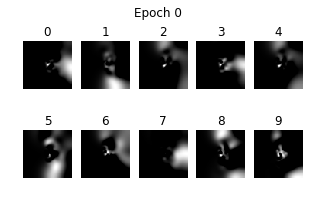

At initialisation, loss = 3.279026985168457


In [72]:
generate_and_save_images(encoder,
                         0,
                         display_digit_images
                         )

loss = encoder_loss(tf.one_hot(digits[:BATCH_SIZE], 11), 
                    mnist_model(tf.map_fn(grid.render_tensor, encoder(digit_images[:BATCH_SIZE])))).numpy()

print(f"At initialisation, loss = {loss}")

In [73]:
save_dir = "./data/training-intermediate-data/"
base = "{dir}/{time}_{type}_{gridType}_{gridParam1}-{gridParam2}_{gridSize1}-{gridSize2}.{ext}"

now = datetime.now().strftime('%Y-%m-%d_%H-%M')

common_format = {
    'time': now,
    'gridType': gridType.__name__,
    'gridParam1': gridParam1,
    'gridParam2': gridParam2,
    'gridSize1': gridSize1,
    'gridSize2': gridSize2,
}

loss_filepath = save_dir + base.format(
    dir="training-losses",
    type='loss',
    ext='log',
    **common_format
)

gif_filepath = save_dir + base.format(
    dir="training-gifs",
    type='evolution',
    ext='gif',
    **common_format
)

grid_filepath = save_dir + base.format(
    dir='training-grids',
    type='grid',
    ext='pkl',
    **common_format
)

encoder_filepath = save_dir + base.format(
    dir='training-encoders',
    type='encoder',
    ext='h5',
    **common_format
)

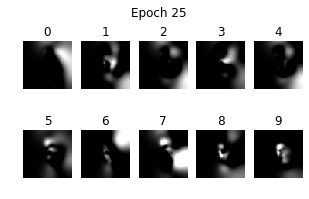

Time for epoch 25 is 37.51802659034729 sec.


KeyboardInterrupt: 

In [74]:
#%%time
train(EPOCHS, loss_filepath)

./03-psychophysics/./data/training-intermediate-data/training-graphs/2019-06-11_14-13_loss_PolarRegularGrid_12-12_64-64.png


'./data/training-intermediate-data/training-graphs/2019-06-11_14-13_loss_PolarRegularGrid_12-12_64-64.png'

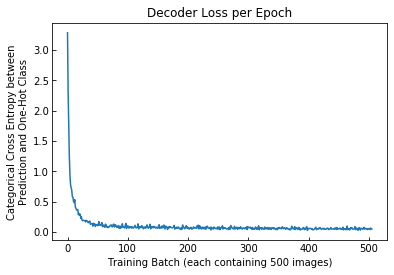

In [84]:
plot_loss(loss_filepath)

In [75]:
generated_images = glob.glob(image_directory + ("*.png"))
images = [PIL.Image.open(image) for image in generated_images]

# save the first image 10 times
images[0].save(gif_filepath,
               save_all=True,
               append_images=[images[0]] * 10 + images + [images[-1]]*10,
               duration=100,
               loop=0)

In [ ]:
pickle.dump(grid, grid_filepath)
encoder.save(encoder_filepath)
# encoder = tf.keras.models.load_model(encoder_filepath)

# Appendix

## Generating Static Digit Images

This script generates static images of centered digits as PNG files.

In [ ]:
from PIL import Image, ImageDraw, ImageFont

baseColour = (0, 0, 0)
baseSizeX, baseSizeY = (16, 16)
textColour = (255, 255, 255)

saveExtension = "png"

for digit in range(10):
    baseImage = Image.new("RGB", (baseSizeY, baseSizeX), baseColour)
    base = ImageDraw.Draw(baseImage)

    text = str(digit)
    textSizeX, textSizeY = base.textsize(text)
    textPosition = (baseSizeX / 2 - textSizeX / 2, baseSizeY / 2 - textSizeY / 2)
    base.text(textPosition, text, textColour)

    saveName = str(digit)
    baseImage.save(f"./data/digit-images/{saveName}.{saveExtension}")

# Blank white
baseImage = Image.new("RGB", (baseSizeY, baseSizeX), (255,255,255))
base = ImageDraw.Draw(baseImage)
baseImage.save(f'./data/digit-images/blank.{saveExtension}')


In [83]:
def plot_loss(logpath):
    with open(logpath) as infile:
        loss_raw = infile.readlines()

    loss_data = np.array(list(map(float, loss_raw)))

 
    plt.plot(range(loss_data.shape[0]), loss_data)
    plt.ylabel("Categorical Cross Entropy between\nPrediction and One-Hot Class")
    plt.xlabel("Training Batch (each containing 500 images)")
    plt.title("Decoder Loss per Epoch")

    plot_file = logpath.replace("losses", "graphs").replace(".log", ".png")
    plt.savefig(plot_file)
    print("./03-psychophysics/" + plot_file)
    return plot_file